In [83]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact

import torch
from torch import nn
from torchsde import BrownianInterval, sdeint

from scipy import special
from torch.autograd import Function

import dgl
import dgl.function as fn

import networkx as nx

import os
import gc
import pickle

# デバイス設定
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


In [84]:
def printNPZ(npz):
    for kw in npz.files:
        print(kw, npz[kw])

In [85]:
dirName = './HiraiwaModel_chem20221102_020319/'

homeName = './'

params = np.load(dirName+'params.npz')
#traj = np.load(dirName+'result.npz')

printNPZ(params)
#printNPZ(traj)

v0 1.0
r 1.0
D 0.1
A 0.0
L 20
rho 1.0
beta 1.0
A_CFs [0.9 0.1]
A_CIL 0.0
cellType_ratio [0.7 0.3]
quiv_colors ['k' 'r']
kappa 1.0
A_Macdonalds [2. 2.]
batch_size 400
state_size 3
brownian_size 1
periodic True
t_max 200
methodSDE heun
isIto False
stepSDE 0.01


In [86]:
subdir_list = [f.path for f in os.scandir(dirName) if f.is_dir()]

print(subdir_list)

datadir_list = [f for f in subdir_list if 'result.npz' in [ff.name for ff in os.scandir(f)]]

print(datadir_list)

['./HiraiwaModel_chem20221102_020319/20221102_194956', './HiraiwaModel_chem20221102_020319/20221102_203311', './HiraiwaModel_chem20221102_020319/20221102_211612', './HiraiwaModel_chem20221102_020319/20221102_215953', './HiraiwaModel_chem20221102_020319/20221102_224239', './HiraiwaModel_chem20221102_020319/20221102_232519', './HiraiwaModel_chem20221102_020319/20221103_000843', './HiraiwaModel_chem20221102_020319/20221103_005036', './HiraiwaModel_chem20221102_020319/20221103_013303', './HiraiwaModel_chem20221102_020319/20221103_021518', './HiraiwaModel_chem20221102_020319/20221103_025758', './HiraiwaModel_chem20221102_020319/20221103_033955', './HiraiwaModel_chem20221102_020319/20221103_042225', './HiraiwaModel_chem20221102_020319/20221103_050424', './HiraiwaModel_chem20221102_020319/20221103_054634', './HiraiwaModel_chem20221102_020319/20221103_062842', './HiraiwaModel_chem20221102_020319/20221103_071105', './HiraiwaModel_chem20221102_020319/20221103_075340', './HiraiwaModel_chem2022110

In [87]:
modeldirName = dirName + 'ActiveNet_vp_rotsym_multiStep_fineTuning_batchNorm/'

#datename = '20220921_160055'
i_model = -1

model_files_list = [[os.path.join(c, ff) for ff in f if ff.endswith('_Model.pt')]
               for c, s, f in os.walk(modeldirName)]
print(model_files_list)

model_files = []
for i in range(len(model_files_list)):
    for j in range(len(model_files_list[i])):
        model_files.append(model_files_list[i][j])
print(model_files)

model_dir = os.path.dirname(model_files[i_model])

model_name = model_files[i_model].replace('_Model.pt', '').replace(modeldirName, '')
print(model_name)

[[], ['./HiraiwaModel_chem20221102_020319/ActiveNet_vp_rotsym_multiStep_fineTuning_batchNorm/20221123_044031/20221123_044031_Model.pt'], [], [], ['./HiraiwaModel_chem20221102_020319/ActiveNet_vp_rotsym_multiStep_fineTuning_batchNorm/20221124_000148/20221124_000148_Model.pt'], [], []]
['./HiraiwaModel_chem20221102_020319/ActiveNet_vp_rotsym_multiStep_fineTuning_batchNorm/20221123_044031/20221123_044031_Model.pt', './HiraiwaModel_chem20221102_020319/ActiveNet_vp_rotsym_multiStep_fineTuning_batchNorm/20221124_000148/20221124_000148_Model.pt']
20221124_000148/20221124_000148


In [88]:
class torch_knFunction(Function):
    @staticmethod
    def forward(ctx, input, n):
        numpy_input = input.cpu().detach().numpy()
        result = special.kn(n, numpy_input)
        return torch.as_tensor(result, dtype=input.dtype, device=device)
    
    @staticmethod
    def backward(ctx, grad_output):
        numpy_go = grad_output.cpu().detach().numpy()
        input, n = ctx.saved_tensors
        numpy_input = input.cpu().detach().numpy()
        if n==0:
            grad_kn = -special.kn(1, numpy_input)
        else:
            grad_kn = -(special.kn(n-1, numpy_input) + special.kn(n+1, numpy_input))/2
        result = numpy_go * grad_kn
        return torch.as_tensor(result, dtype=input.dtype, device=device)

class torch_kn(nn.Module):
    def __init__(self, n):
        super(torch_kn, self).__init__()
        self.n = n
        
    def forward(self, input):
        return torch_knFunction.apply(input, self.n)
    
torch_scipy_k0 = torch_kn(0)
torch_scipy_k1 = torch_kn(1)

cutoff = torch.tensor([3.5], device = device)
k1_cutoff = torch_scipy_k1(cutoff)

func_cutoff = nn.ReLU()

def torch_scipy_k1_cutoff(x):
    return func_cutoff(torch_scipy_k1(x) - k1_cutoff)

In [89]:
def J_chemMacdonald(xy, d): # cutoff! --> shift the values
    chemMag = torch_scipy_k1_cutoff(params['kappa'].item() * d) *(params['kappa'].item()/(2*np.pi))
    xy = chemMag * xy
    return xy #torch.nansum(xy, dim=0, keepdim=False)    

if params['periodic']:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T   # neighbor - target
        dy = xy[:, 1:] - xy[:, 1:].T
        dx = dx % L
        dy = dy % L
        dx[dx > L/2] = dx[dx > L/2] - L
        dy[dy > L/2] = dy[dy > L/2] - L
        return [dx, dy]
else:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T
        dy = xy[:, 1:] - xy[:, 1:].T
        return [dx, dy]    

def J_CF(xy, dr, q):
    #c = torch.unsqueeze(q[0], 1)   # cos, sin of neighbor
    #s = torch.unsqueeze(q[1], 1)
    c = q[:,:1]
    s = q[:,1:]
    xy = (1 + xy[...,:1] * c + xy[...,1:] * s) * xy / 2
    return xy #torch.nansum(xy, dim=0, keepdim=False)

def J_CIL(xy, d, r):
    xy = ((r/d) - 1) * xy
    return xy #torch.nansum(xy, dim=0, keepdim=False)

In [90]:
isIto = params['isIto']

class SDE(torch.nn.Module):
    noise_type = 'scalar'
    sde_type = 'ito' if isIto else 'stratonovich'

    def __init__(self, L, periodic, v0, beta, A_CF, A_CIL, r, A, D):
        super().__init__()
        self.L = L
        self.periodic = periodic
        self.v0 = v0
        self.beta = beta
        self.A_CF = A_CF
        self.A_CIL = A_CIL
        self.r = r
        self.A = A

        self.sigma = torch.zeros((batch_size, state_size, 1), device=device)
        self.sigma[:, 2, 0] = np.sqrt(2*D)
        
    # Drift
    def f(self, t, y):
#        print(y.shape)
        xy = y[:, :2]
#        if self.periodic:
#            xy = xy % L
        xy = xy2distance(xy, self.L)
#        print(np.shape(xy))
#        print(xy[0].shape)
        xy = torch.cat((torch.unsqueeze(xy[0], 2), torch.unsqueeze(xy[1], 2)), 2)
        d = torch.norm(xy, p='fro', dim=2, keepdim=True)   # distance
        dr = torch.heaviside(self.r - d, torch.tensor([0.0], device=device))   # 1 if distance < r, else 0
        xy = dr * torch.nn.functional.normalize(xy, p=2.0, dim=2)   # normalized distance vector
        c = torch.cos(y[:, 2:])
        s = torch.sin(y[:, 2:])

        jcil = J_CIL(xy, d, self.r)
        
        jchem = J_chemMacdonald(xy, d)
        
        dx0 = self.v0 * torch.cat((c, s), 1)
        dx1 = -self.beta * jcil
        dtheta0 = self.A_CF * J_CF(xy, dr, [c,s]) - self.A_CIL * jcil
        dtheta0 = c * dtheta0[:, 1:] - s * dtheta0[:, :1]
        dtheta1 = self.A * c
        dtheta2 = A_Macdonald * (c * jchem[:, 1:] - s * jchem[:, :1])
        return torch.cat((dx0+dx1, dtheta0+dtheta1+dtheta2), 1)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma


In [91]:
if params['periodic']:
    L = torch.tensor(params['L'])
    def calc_dr(r1, r2):
        dr = torch.remainder((r1 - r2), L)
        dr[dr > L/2] = dr[dr > L/2] - L
        return dr
else:
    def calc_dr(r1, r2):
        return r1 - r2
    
def makeGraph(x_data, r_thresh):
        Ndata = x_data.size(0)
        dx = calc_dr(torch.unsqueeze(x_data, 0), torch.unsqueeze(x_data, 1))
        dx = torch.sum(dx**2, dim=2)
        edges = torch.argwhere(dx < r_thresh/2)
        return dgl.graph((edges[:,0], edges[:,1]), num_nodes=Ndata)

In [92]:
def self_propel(p):
    return p * params['v0']

def angle_abs(xy):
    #xy = xy2distance(xy, params['L'])
    #xy = torch.cat((torch.unsqueeze(xy[0], -1), torch.unsqueeze(xy[1], 2)), -1)
    #xy = calc_dr(r_i, r_j)
    d = torch.norm(xy, p='fro', dim=-1, keepdim=True)   # distance
    dr = torch.heaviside(params['r'].item() - d, torch.tensor([0.0], device=xy.device))   # 1 if distance < r, else 0
    xy = dr * torch.nn.functional.normalize(xy, p=2.0, dim=-1)
    return xy, d

def interact_a(xy, d):
    return -params['beta'] * J_CIL(xy, d, params['r'].item())

def torque(xy, d, p_src, p_dst, type_dst):
    jchem = J_chemMacdonald(xy, d)
    dtheta0 = torch.tensor(params['A_CFs'], device=xy.device)[type_dst.long()] * J_CF(xy, 0, p_src) - params['A_CIL'].item() * J_CIL(xy, d, params['r'].item())
    dtheta0 = p_dst[..., :1] * dtheta0[..., 1:] - p_dst[..., 1:] * dtheta0[..., :1]
    dtheta1 = params['A'].item() * p_dst[..., :1]
    dtheta2 = torch.tensor(params['A_Macdonalds'], device=xy.device)[type_dst.long()] * (p_dst[..., :1] * jchem[..., 1:] - p_dst[..., 1:] * jchem[..., :1])    
    return dtheta0 + dtheta1 + dtheta2

In [93]:
class NeuralNet(nn.Module):
    def __init__(self, in_channels, out_channels, Nchannels, dropout=0, batchN=False, flgBias=False):
        super(NeuralNet, self).__init__()

        if dropout:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = 0
            
        if batchN:
            self.bNorm1 = nn.BatchNorm1d(Nchannels)
            self.bNorm2 = nn.BatchNorm1d(Nchannels)
            self.bNorm3 = nn.BatchNorm1d(Nchannels)
            
        self.batchN=batchN
        
        self.layer1 = nn.Linear(in_channels, Nchannels, bias=flgBias)
        self.layer2 = nn.Linear(Nchannels, Nchannels, bias=flgBias)
        self.layer3 = nn.Linear(Nchannels, Nchannels, bias=flgBias)
        self.layer4 = nn.Linear(Nchannels, out_channels, bias=flgBias)

        self.activation = nn.ReLU()

    def reset_parameters(self):
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
        self.layer3.reset_parameters()
        self.layer4.reset_parameters()
        #nn.init.zeros_(self.layer1.weight)
        #nn.init.zeros_(self.layer2.weight)
        #nn.init.zeros_(self.layer3.weight)
        #nn.init.zeros_(self.layer4.weight)
        
    def forward(self, x):
        out = self.activation(self.layer1(x))
        if self.batchN:
            out = self.bNorm1(out)
        if self.dropout:
            out = self.dropout(out)
        
        out = self.activation(self.layer2(out))
        if self.batchN:
            out = self.bNorm2(out)
        if self.dropout:
            out = self.dropout(out)
        
        out = self.activation(self.layer3(out))
        if self.batchN:
            out = self.bNorm3(out)
        if self.dropout:
            out = self.dropout(out)
        
        out = self.layer4(out)

        return out

class ActiveNet(nn.Module):
    def __init__(self, xy_dim, r, dropout=0, batchN=False, bias=False, Nchannels=128):
        super().__init__()

        self.interactNN = NeuralNet(xy_dim*2 + 2, xy_dim, Nchannels, dropout, batchN, bias)

        self.thetaDotNN = NeuralNet(xy_dim*2 + 2, 1, Nchannels, dropout, batchN, bias)
        
        self.selfpropel = nn.Parameter(torch.tensor(0.0, requires_grad=True, device=device))

        #self.Normalizer = nn.Softmax(dim=1)

        self.xy_dim = xy_dim
        
        self.r = r

        self.reset_parameters()

    def reset_parameters(self):
        self.interactNN.reset_parameters()

        self.thetaDotNN.reset_parameters()
        
        nn.init.uniform_(self.selfpropel)

        #self.bias.data.zero_()
        
    def load_celltypes(self, celltype):
        self.celltype = celltype

    def calc_message(self, edges):
        dx = calc_dr(edges.dst['x'], edges.src['x'])#mistake ... calculating x_dst - x_src (should be flipped)

        costheta = torch.cos(edges.dst['theta'])
        sintheta = torch.sin(edges.dst['theta'])

        dx_para = costheta * dx[..., :1] + sintheta * dx[..., 1:]
        dx_perp = costheta * dx[..., 1:] - sintheta * dx[..., :1]

        p_para_src = torch.cos(edges.src['theta'] - edges.dst['theta'])
        p_perp_src = torch.sin(edges.src['theta'] - edges.dst['theta'])

        rot_m_v = self.interactNN(torch.concat((dx_para, dx_perp, 
                                                p_para_src, p_perp_src,
                                                edges.dst['type'], edges.src['type']), -1))

        m_v = torch.concat((costheta * rot_m_v[..., :1] - sintheta * rot_m_v[..., 1:],
                            costheta * rot_m_v[..., 1:] + sintheta * rot_m_v[..., :1]), -1)

        m_theta = self.thetaDotNN(torch.concat((dx_para, dx_perp, 
                                                p_para_src, p_perp_src, 
                                                edges.dst['type'], edges.src['type']), -1))
        
        return {'m': torch.concat((m_v, m_theta), -1)}
        
    def forward(self, xv):
        r_g = makeGraph(xv[..., :self.xy_dim], self.r/2)
        r_g.ndata['x'] = xv[..., :self.xy_dim]
        r_g.ndata['theta'] = xv[..., self.xy_dim:(self.xy_dim+1)]
        r_g.ndata['type'] = self.celltype
        r_g.update_all(self.calc_message, fn.sum('m', 'a'))
        r_g.ndata['a'][..., :self.xy_dim] = r_g.ndata['a'][..., :self.xy_dim] + self.selfpropel * torch.concat((torch.cos(r_g.ndata['theta']), torch.sin(r_g.ndata['theta'])), -1)
        
        return r_g.ndata['a']



In [94]:
filename1 = modeldirName + model_name + '_Model.pt'
gnn_model = torch.load(filename1, map_location=torch.device(device)) #pickle.load(open(filename1, 'rb'))
gnn_model.eval()

filename3 = modeldirName + model_name + '_Separation.npz'
learn_params = np.load(filename3, allow_pickle=True)

printNPZ(learn_params)

dr_thresh 14
T_pred 10
batch_size 8
train_inds [21  8  0 19 24  5  7 15  3  1 10  2 12 13 11 16 20  4 17  6]
valid_inds [ 9 23 18]
test_inds [14 22]
val_loss_log [[2.19233502 0.21313945]
 [2.19976233 0.21335003]
 [2.18387046 0.21303355]
 [2.17434082 0.21263533]
 [2.17213126 0.21246868]
 [2.17927002 0.21274202]
 [2.17236869 0.21268875]
 [2.1733518  0.21258251]
 [2.16911663 0.21256024]
 [2.16052435 0.21221372]
 [2.15906892 0.21225983]
 [2.15794183 0.21200069]
 [2.16137561 0.21199453]
 [2.15812096 0.21207714]
 [2.15819593 0.21223843]
 [2.15592668 0.21196562]
 [2.15166089 0.21200034]
 [2.15474297 0.2120592 ]
 [2.15210899 0.21198387]
 [2.13917666 0.21170581]
 [2.13737277 0.21176228]
 [2.13191001 0.21155984]
 [2.13563489 0.21161216]
 [2.13255164 0.21131821]
 [2.12802422 0.21144736]
 [2.13171103 0.21171719]
 [2.13412866 0.21169016]
 [2.13465133 0.21143291]
 [2.13705025 0.21156945]
 [2.13057435 0.21150114]
 [2.12983202 0.21141512]
 [2.12863703 0.21140988]
 [2.12829101 0.21149178]
 [2.12895711 

In [95]:
# threshold distance for making edges
dr_thresh = learn_params['dr_thresh'].item()

# fixed noise strength
D = 0.0 #params['D']

# boundary conditions (L=100 in article)
#L = params['L']
periodic = params['periodic']

# cell type ratio
cellType_ratio = params['cellType_ratio']
quiv_colors = params['quiv_colors']

# numbers of cells, freedom, and noise source
batch_size, state_size, brownian_size = params['batch_size'], 3, 1

# duration of simulation (6400 in the article)
t_max =  params['t_max']# - initTime

# method to solve SDE
#methodSDE = 'euler'
#isIto = True

# time step to simulate
stepSDE = 1


In [96]:
print(gnn_model.state_dict())

OrderedDict([('selfpropel', tensor(1.0523, device='cuda:1')), ('interactNN.layer1.weight', tensor([[ 3.3675e-01, -6.9976e-02,  5.3580e-01,  9.7933e-02,  2.6164e-02,
          3.2565e-02],
        [ 6.3833e-02, -5.3582e-01,  1.5382e-01,  1.3953e-01,  3.1075e-01,
          9.5802e-03],
        [-4.0691e-01,  8.6980e-01,  4.0198e-02, -2.7587e-01, -1.9606e-01,
          1.1886e-01],
        [ 1.6103e-01,  3.3775e-02, -3.6344e-02,  7.0101e-02, -6.4818e-02,
         -4.8002e-01],
        [-5.2035e-01,  2.5383e-01,  1.1622e-01, -2.2947e-01, -1.0827e-02,
          1.3840e-03],
        [-9.7616e-02, -1.2035e-01,  3.3222e-01,  1.1888e-01, -3.4079e-01,
          3.2821e-02],
        [ 7.5998e-02, -1.9791e-01,  4.3920e-01, -6.1144e-03, -4.5586e-02,
          5.7245e-02],
        [ 9.6095e-01,  8.7868e-02, -4.9383e-01,  1.7596e-01, -1.1651e-01,
          1.8693e-01],
        [ 1.5098e-01,  3.9928e-01,  3.9144e-02, -4.0493e-01, -1.8067e-02,
         -8.1111e-03],
        [ 9.1149e-01, -3.1948e-01, -

In [97]:
gnn_model.state_dict()['selfpropel']

tensor(1.0523, device='cuda:1')

In [98]:
gnn_model.thetaDotNN

NeuralNet(
  (layer1): Linear(in_features=6, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=1, bias=True)
  (activation): ReLU()
)

In [99]:
plt.rcParams['font.size']=18
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['savefig.bbox'] = 'tight'

plt.rcParams['lines.markersize'] = 11.0

plt.rcParams['lines.linewidth'] = 3.5

In [100]:
# make input dummy data

max_distance = dr_thresh/4

dx_grid = torch.linspace(-max_distance, max_distance, 40)
dy_grid = torch.linspace(-max_distance, max_distance, 40)

p_dst = torch.tensor([1.0, 0.0], device=device)

thetap_src = torch.arange(0, 2*np.pi, np.pi/12)
#p_src = torch.stack((torch.cos(thetap_src), torch.sin(thetap_src)), 1).view(1,1,24,2)

type_dst = torch.tensor([0., 1.])
type_src = torch.tensor([0., 1.])

in_grid = torch.cartesian_prod(dx_grid, dy_grid, thetap_src, type_dst, type_src)

in_grid = torch.cat((in_grid[..., :2], torch.cos(in_grid[..., 2:3]),
                     torch.cos(in_grid[..., 2:3]), in_grid[..., 3:]), -1).to(device)

in_grid_shape = [dx_grid.size(0), dy_grid.size(0), thetap_src.size(0), type_dst.size(0), type_src.size(0), 6]

out_grid_shape = in_grid_shape.copy()
out_grid_shape[-1] = -1

In [101]:
print(in_grid_shape)

[40, 40, 24, 2, 2, 6]


In [102]:
with torch.no_grad():
    interact_pred = gnn_model.interactNN(in_grid.view(-1, 6).to(device))
    interact_pred = interact_pred.cpu().reshape(out_grid_shape)
    torque_pred = gnn_model.thetaDotNN(in_grid.view(-1, 6).to(device)).cpu().reshape(out_grid_shape)

In [103]:
with torch.no_grad():
    xy_in, d_in = angle_abs(in_grid[..., :2].view(-1, 2).to(device))
    interact_truth = interact_a(-xy_in, d_in).cpu().reshape(out_grid_shape)
    torque_truth = torque(-xy_in, d_in, in_grid[:,2:4], p_dst.view(-1, 2), in_grid[:, 4:5]).cpu().reshape(out_grid_shape)

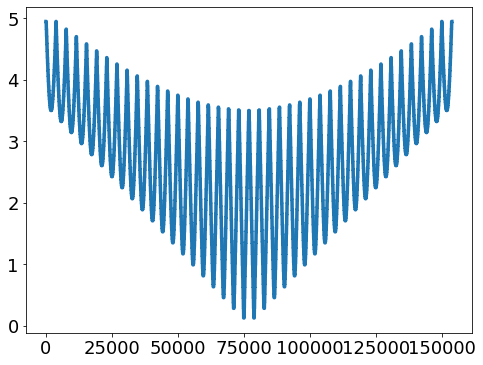

In [104]:
plt.plot(d_in.cpu())

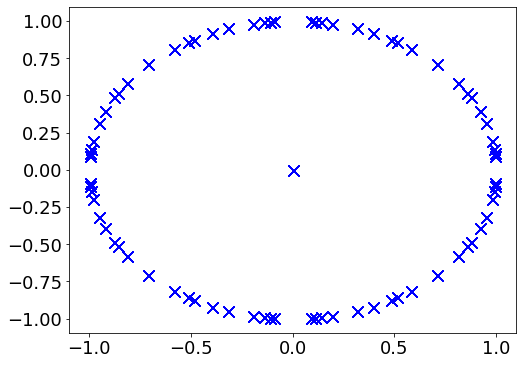

In [105]:
plt.plot(xy_in[:,0].cpu(), xy_in[:,1].cpu(), 'bx')

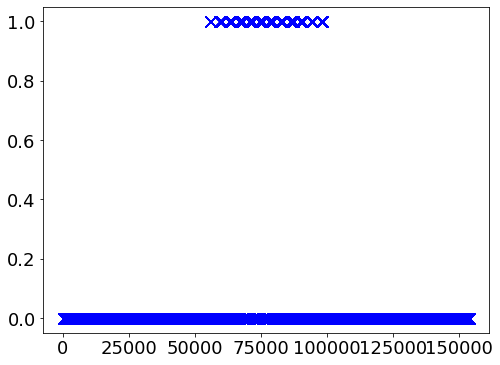

In [106]:
plt.plot((xy_in.cpu()**2).sum(dim=1), 'bx')

In [107]:
print(interact_pred)

tensor([[[[[[ 7.2077e-01, -4.2774e-01],
            [ 7.0656e-01, -4.1654e-01]],

           [[ 7.4019e-01, -4.4292e-01],
            [ 7.3063e-01, -4.2285e-01]]],


          [[[ 7.2319e-01, -4.2788e-01],
            [ 7.0822e-01, -4.1618e-01]],

           [[ 7.4277e-01, -4.4249e-01],
            [ 7.3244e-01, -4.2227e-01]]],


          [[[ 7.3028e-01, -4.2829e-01],
            [ 7.1483e-01, -4.1605e-01]],

           [[ 7.5032e-01, -4.4121e-01],
            [ 7.3917e-01, -4.2131e-01]]],


          ...,


          [[[ 7.3514e-01, -4.2760e-01],
            [ 7.2715e-01, -4.1713e-01]],

           [[ 7.6294e-01, -4.3965e-01],
            [ 7.5173e-01, -4.2075e-01]]],


          [[[ 7.3028e-01, -4.2829e-01],
            [ 7.1483e-01, -4.1605e-01]],

           [[ 7.5032e-01, -4.4121e-01],
            [ 7.3917e-01, -4.2131e-01]]],


          [[[ 7.2319e-01, -4.2788e-01],
            [ 7.0822e-01, -4.1618e-01]],

           [[ 7.4277e-01, -4.4249e-01],
            [ 7.3244e-01, -4.22

In [108]:
print(interact_truth)

tensor([[[[[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          ...,


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]]],



         [[[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          ...,


          [[[0., 0.],
            [0., 0.]],

           [[0., 0.],
            [0., 0.]]],


          [[[0., 0.],
  

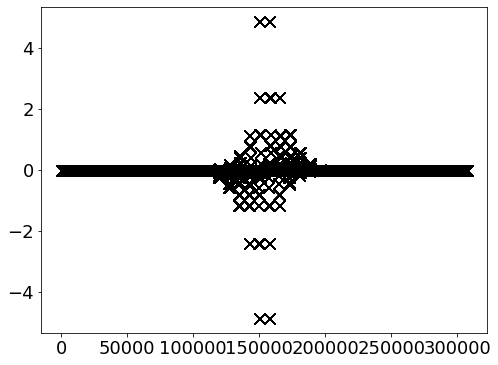

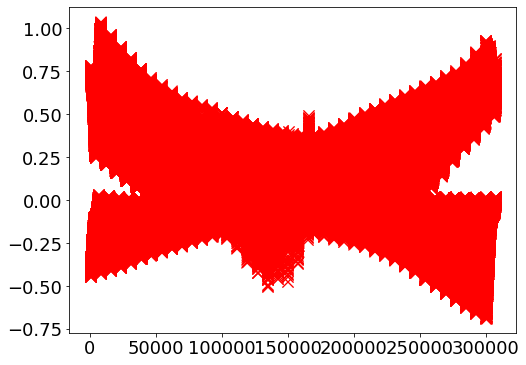

In [109]:
fig,ax = plt.subplots()
ax.plot(interact_truth.cpu().view(-1), 'kx')
fig,ax = plt.subplots()
ax.plot(interact_pred.cpu().view(-1), 'rx')

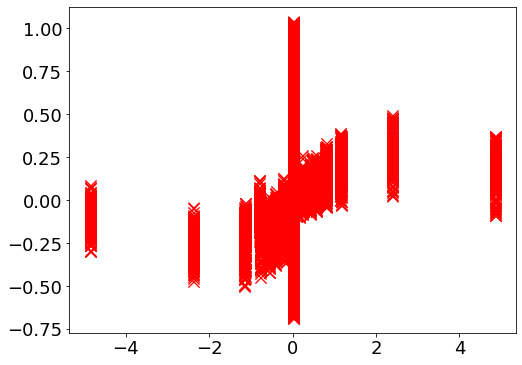

In [110]:
fig,ax = plt.subplots()
ax.plot(interact_truth.cpu().view(-1), interact_pred.cpu().view(-1), 'rx')

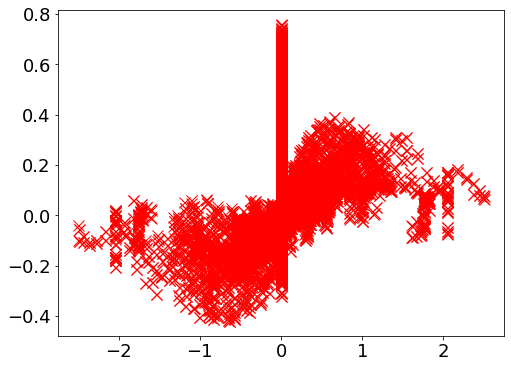

In [111]:
fig,ax = plt.subplots()
ax.plot(torque_truth.cpu().view(-1), torque_pred.cpu().view(-1), 'rx')

In [112]:
plt.rcParams['font.size']=18
plt.rcParams['figure.figsize'] = [18,12]
plt.rcParams['savefig.bbox'] = 'tight'

plt.rcParams['image.cmap'] = 'magma'

plt.rcParams['lines.markersize'] = 11.0

plt.rcParams['lines.linewidth'] = 3.5

In [113]:
clim_interact_true = [-4,4]
clim_torque_true = [-1.2,1.2]

clim_interact_pred = [-0.8,0.8]
clim_torque_pred = [-0.5,0.5]

dy_true, dx_true = np.meshgrid(dx_grid, dy_grid)
dy_pred, dx_pred = np.meshgrid(dx_grid, dy_grid)

def pcolor_subplots(N_i, N_j, ij, xg, yg, cg, cl, title):
    plt.subplot(N_i,N_j,ij)
    plt.pcolor(xg, yg, cg, clim=cl)
    plt.colorbar()
    plt.title(title)
    plt.axis('equal')

@interact(theta_p_j=(0, in_grid_shape[2]-1), type_i=(0, in_grid_shape[3]-1), type_j=(0, in_grid_shape[4]-1))
def f(theta_p_j, type_i, type_j):
    fig = plt.figure()
    pcolor_subplots(3,2,1, dx_true, dy_true, interact_truth[:,:,theta_p_j,type_i,type_j,0], clim_interact_true, 'true interact vx')
    pcolor_subplots(3,2,3, dx_true, dy_true, interact_truth[:,:,theta_p_j,type_i,type_j,1], clim_interact_true, 'true interact vy')
    pcolor_subplots(3,2,5, dx_true, dy_true, torque_truth[:,:,theta_p_j,type_i,type_j,0], clim_torque_true, 'true dtheta/dt')
    pcolor_subplots(3,2,2, dx_pred, dy_pred, interact_pred[:,:,theta_p_j,type_i,type_j,0], clim_interact_pred, 'pred interact vx')
    pcolor_subplots(3,2,4, dx_pred, dy_pred, interact_pred[:,:,theta_p_j,type_i,type_j,1], clim_interact_pred, 'pred interact vy')
    pcolor_subplots(3,2,6, dx_pred, dy_pred, torque_pred[:,:,theta_p_j,type_i,type_j,0], clim_torque_pred, 'pred dtheta/dt')
        


interactive(children=(IntSlider(value=11, description='theta_p_j', max=23), IntSlider(value=0, description='ty…